In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Generate Grayscale images of size 64 x 64 in the form of frequency domain low pass filter

In [ ]:
num_Images = 4000
img_Size = 64
crow, ccol = img_Size/2 , img_Size/2
center = [crow, ccol]

imgs = torch.zeros(num_Images,1,img_Size,img_Size)

for i in range(num_Images):
    r = np.random.randint(15, 30, (1,))

    x, y = np.ogrid[:img_Size, :img_Size]
    mask = np.zeros((img_Size, img_Size))
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask[mask_area] = 1
    imgs[i,:,:,:] = torch.Tensor(mask).view(1,img_Size,img_Size)

In [ ]:
imgs.shape

torch.Size([4000, 1, 64, 64])

# Visualizing the images

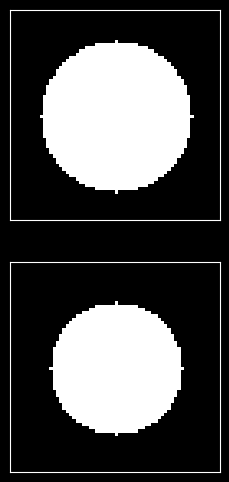

In [ ]:
# visualize some images
fig,axis = plt.subplots(2,1,figsize=(6,6))

for i,ax in enumerate(axis.flatten()):
  which_img = np.random.randint(num_Images)
  mask = np.squeeze( imgs[which_img,:,:] )
  ax.imshow(mask,vmin=0,vmax=1,cmap='gray') # cmap = 'gray' or 'rainbow'
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
# Code inspired from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Create Discriminator Class

In [ ]:
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()


    self.conv1 = nn.Conv2d(  1, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):

    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)

# Check Discriminator

In [ ]:
disModel = discriminator()
out = disModel(torch.randn(10,1,64,64))
print(out.shape)

torch.Size([10, 1])


# Create Generator Class

In [ ]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x

# See what generator is producing before training

torch.Size([10, 1, 64, 64])


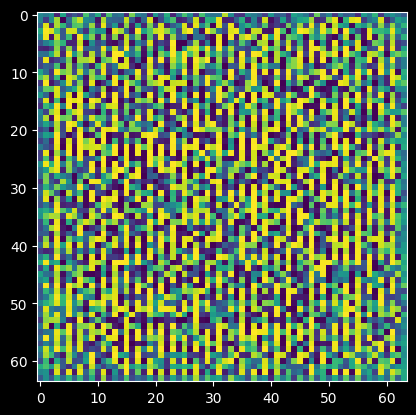

In [ ]:
genModel = generator()
out = genModel(torch.randn(10,100,1,1))
print(out.shape)
plt.imshow(out[0,:,:,:].squeeze().detach().numpy());

# Define Loss Function

In [ ]:
lossfunc = nn.BCELoss()

# Push the Models to GPU

In [ ]:
disModel = disModel.to(device)
genModel = genModel.to(device)

# Set the Optimizers

In [ ]:
dis_optimizer = torch.optim.Adam(disModel.parameters(), lr=.0002, betas=(.5,.999))
gen_optimizer = torch.optim.Adam(genModel.parameters(), lr=.0002, betas=(.5,.999))

# Train the DCGAN

In [ ]:
epochs = 2001
batchsize = 32
losses  = np.zeros((epochs,2)) # (num_epochs,2) because we have to train two models i.e generator and discriminator.
dis_output = np.zeros((epochs,2)) # dis_output = discriminator decisions

for epoch in range(epochs):

  rand_idx = np.random.choice(imgs.shape[0], size= batchsize)
  real_images = imgs[rand_idx,:].to(device) # Real Images are generated from the real data (dataT)
  fake_images = genModel( torch.randn(batchsize,100,1,1).to(device) ) # Fake images are generated from the output of generator
                                                                 # by sending random input number to generator.


  # Creating Labels used for real and fake images

  real_labels = torch.ones(batchsize,1).to(device) # All ones means true because they are real labels
  fake_labels = torch.zeros(batchsize,1).to(device) # All zeros means false because they are fake labels


  # TRAIN THE DISCRIMINATOR

  # Forward pass and loss for REAL Images   (step1 of discriminator training)

  ypred_real   = disModel(real_images)                 # REAL images into discriminator
  dis_loss_real = lossfunc(ypred_real, real_labels)    # All labels are 1. In order to reduce loss model should learn to predict 1
                                                       # for real images

  # In the above step1 of training discriminator, we pass all real images to discriminator
  # and the comparing Ypred_real (predictions of discriminator) with real_labesl(all ones).
  # This is our loss which we have to minimize.



  # Forward pass and loss for FAKE Images (step 2 of discriminator training)

  ypred_fake   = disModel(fake_images)              # FAKE images into discriminator
  dis_loss_fake = lossfunc(ypred_fake, fake_labels)   # All labels are 0. In order to reduce loss model should learn to predict 0
                                                      # for fake images

  # Calculate combined loss.

  dis_loss = dis_loss_real + dis_loss_fake
  losses[epoch,0]  = dis_loss.item()   # loss will be accumulated along the first column
  dis_output[epoch,0] = torch.mean((ypred_real>.5).float()).detach() # This line is storing the model decision.


  # Backpropagation for discriminator

  dis_optimizer.zero_grad()
  dis_loss.backward()
  dis_optimizer.step()




  # TRAIN THE GENERATOR

  # Create the fake images and compute loss

  fake_images = genModel( torch.randn(batchsize,100,1,1).to(device) )
  ypred_fake   = disModel(fake_images)

  # In above two lines of code, we generate fake images from the generator
  # and pass the fake images through discriminator to get the predictions.




  # Compute loss and accuracy
  gen_loss = lossfunc(ypred_fake, real_labels)   # Here we comparing the predictions of
                                                 # of discriminator with the real_labels to get the loss of generator
                                                 # In this step we are trying to deceive to discriminator that our images are real. if
                                                 # discriminator accepts this then there is no loss, otherwise we need to train generator
                                                 # more so that it can fool the discriminator.
  losses[epoch,1]  = gen_loss.item()
  dis_output[epoch,1] = torch.mean((ypred_fake>.5).float()).detach()

  # Backpropagation of generator.

  gen_optimizer.zero_grad()
  gen_loss.backward()
  gen_optimizer.step()


  # printing the epochs
  if (epoch)%50==0:
    print(f' Epochs : {epoch}/{epochs}')



 Epochs : 0/2001


# Visualize the performance

In [ ]:
plt.figure(figsize=(18,7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('Model loss', fontsize = 25)
plt.legend(['Discrimator','Generator'])
# plt.xlim([9000,15000])
# plt.ylim([0,5])
plt.show()

In [ ]:
plt.figure(figsize=(18,7))
plt.plot(dis_output) # This shows the probability with which discriminator predicts that the data is real or fake
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Probablity',fontsize = 15)
plt.title('Discriminator output', fontsize = 25)
plt.legend(['Real','Fake'], fontsize = 15)
plt.show()

# Test the generator on Random Samples

In [ ]:
Noise = torch.randn(batchsize,100,1,1)

In [ ]:
plt.imshow(Noise.squeeze())

In [ ]:
genModel.eval()
fake_data = genModel(Noise.to(device))
fake_data = fake_data.cpu()

In [ ]:
fig,axis = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axis.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='gray')
  ax.axis('off')
plt.show()